In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from collections import defaultdict
import string

USER_NAME = 'zj2244'
USER_NAME = 'jzf02'

DATA_FRAME1 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company\temp_datalab_records_linkedin_company.csv"
DATA_FRAME1 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company.zip"
DATA_FRAME2 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings\temp_datalab_records_job_listings.csv"
DATA_FRAME3 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_social_facebook.zip"
#CSV_A = [r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings" + "_%d"%_k+".zip" for _k in range(1,7)]
CSV_A = [r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings" + " (%d)"%_k+".zip" for _k in range(1,8)]
CSV_B = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company.zip"
CSV_C = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_social_facebook.zip"


In [2]:
df2 = pd.read_csv(CSV_B)
#df1 = pd.read_csv(DATA_FRAME2)
#df3 = pd.read_csv(CSV_C)

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def read_domains(domain_names, chunk=100000):
    df_list = []
    columns = ['domain', 'as_of_date', 'title', 'listing_id', 'posted_date', 'country']
    for filename in CSV_A:
        df_reader = pd.read_csv(filename, chunksize=chunk, infer_datetime_format=True, parse_dates=['as_of_date', 'posted_date'])
        count = 0
        for curr_df in df_reader:
            count += 1
            domains = set(curr_df['domain'])
            common = set()
            for domain in domains:
                matched = False
                for name in domain_names:
                    if name in domain:
                        matched = True
                        break
                if matched:
                    common.add(domain)
            df_list.append(curr_df[curr_df['domain'].isin(common)][columns].copy())
            if count % 10 == 0:
                print('Finished reading %d chunks of %s'%(count, filename))
    return pd.concat(df_list)
                
            
    

In [4]:
mask = (df2['as_of_date'] == df2['as_of_date'].max())& (df2['industry'].isin(['Pharmaceuticals', 'Biotechnology']))
df_bio = df2[mask].copy()
df_bio.sort_values(by='followers_count', inplace=True, ascending=False)


bio_companies = set(df2['company_name'][df2['industry'].isin(['Pharmaceuticals', 'Biotechnology'])])
bio_short = [_k.split()[0].lower() for _k in bio_companies]
#bio_short
#df2[df2['company_name'].str.contains('Lilly')]

df_bio.head(10)
df_bio.head()
domain_names = df_bio['website'].apply(lambda t: t.split('.')[-2].split('/')[-1] if type(t) == str else '')
curr_names = list(domain_names)[:10]
data = read_domains(curr_names)
data.to_pickle('data_bio7.pkl')

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 10 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 20 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 30 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 40 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 50 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 60 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 70 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 80 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 90 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 100 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 110 chunks o

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 360 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 370 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 380 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 390 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 400 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 410 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 420 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 430 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 440 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 450 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 460 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 470 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 480 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 490 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 500 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 510

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 530 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,7,8,9,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 540 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 550 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 560 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 570 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 580 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 590 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 600 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 610 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 620 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (1).zip
Finished reading 10 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (2).zip
Finished reading 20 c

Finished reading 140 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 150 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 160 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 170 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 180 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 190 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 200 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 210 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 220 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 230 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 240

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,7,8,9,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 310 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 320 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 330 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 340 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 350 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 360 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 370 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 380 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 390 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 400 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (3).zip
Finished reading 410

Finished reading 20 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 30 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 40 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 50 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 60 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 70 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 80 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 90 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 100 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip


C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 110 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 120 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 130 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 140 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 150 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 160 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 170 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 180 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 190 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 200 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (5).zip
Finished reading 210

C:\Users\jzf02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (6,7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Finished reading 20 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 30 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 40 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 50 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 60 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 70 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 80 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 90 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 100 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 110 chunks of C:\Users\jzf02\Downloads\temp_datalab_records_job_listings (6).zip
Finished reading 120 chunks 

In [5]:
grouped = data[['domain', 'as_of_date', 'title', 'listing_id', 'posted_date']].groupby('listing_id')
dur = grouped.min()
dur['Duration'] = grouped.max()['as_of_date'] - dur['as_of_date']


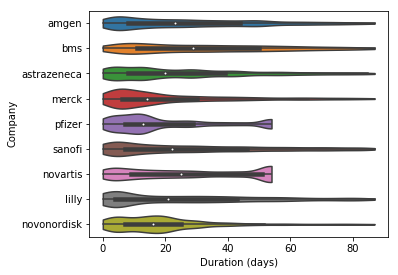

In [22]:
domain_map = defaultdict(str)
curr_names = domain_names[:10]

for domain in set(dur['domain']):
    for domain_name in curr_names:
        if domain_name in domain:
            domain_map[domain] = domain_name

dur['Days'] = dur['Duration'].apply(lambda t:t.days)
dur['Name'] = dur['domain'].apply(lambda t: domain_map[t] )
dur_1s = dur['Days'].mean() + 1*dur['Days'].std()
ax1 = sns.violinplot(data=dur[dur['Days']<dur_1s], x = 'Days', y='Name', cut=0)
ax1.set_ylabel('Company')
ax1.set_xlabel('Duration (days)')
#ax1.set_xlim(0, 80)
plt.tight_layout(rect=[0.06, 0.02, 1, 1])

plt.savefig('fig_posting_1.png', dpi=300)
plt.show()

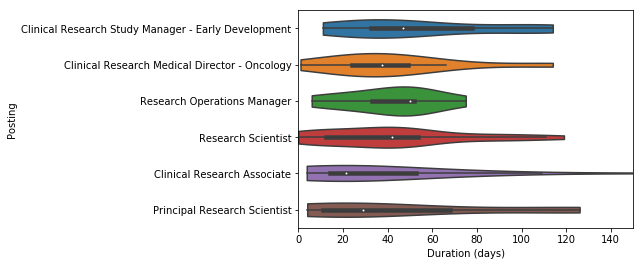

In [23]:
grouped = dur.groupby('title')
df_title = grouped.count().sort_values('domain', ascending=False)

top_titles = (df_title.index[df_title.index.str.contains('Research')])

ax1 = sns.violinplot(data=dur[dur['title'].isin(top_titles[:6])], x='Days', y='title', cut=0)
#labels = ax1.get_yticklabels()
#ax1.set_yticklabels(labels, rotation=90)
ax1.set_ylabel('Posting')
ax1.set_xlabel('Duration (days)')
ax1.set_xlim(0, 150)
#plt.tight_layout()

plt.savefig('fig_posting_2.png', dpi=300)
plt.show()


In [16]:
dur.mean()+dur.std()*3

Days    185.649692
dtype: float64